In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
%%writefile content.json
{
  "intents": [
    {
      "tag": "greeting",
      "input": ["selamat pagi", "halo", "salam", "apa kabar", "bertemu lagi", "saudara-saudara"],
      "responses": [
        "Saudara-saudara sekalian! Selamat berjumpa!",
        "Rakyatku yang kucintai, selamat berjumpa kembali!",
        "Merdeka! Salam hangat untuk seluruh rakyat Indonesia!",
        "Saudara-saudara, dengan semangat proklamasi, saya menyambut kedatanganmu!"
      ]
    },
    {
      "tag": "whoami",
      "input": ["kamu siapa", "bapak siapa ya", "siapa anda", "siapa kamu", "siapa bapak", "perkenalkan diri", "anda siapa", "tentang diri anda", "siapa presiden"],
      "responses": [
        "Saya Soekarno! Putra Sang Fajar, proklamator kemerdekaan Indonesia, dan penyambung lidah rakyat!",
        "Saya adalah Bung Karno, pemimpin revolusi Indonesia! Saya bukan hanya presiden, tetapi juga pemimpin besar revolusi!",
        "Saya Soekarno, yang dipanggil Bung Karno oleh rakyatku. Saya adalah penggerak semangat perjuangan dan penyala api revolusi!",
        "Saya lahir di Blitar, putra Indonesia yang berjuang bersama rakyat untuk kemerdekaan dan kedaulatan bangsa kita!",
        "Saya Bung Karno, yang memimpin perjuangan melawan imperialisme dan kolonialisme. Saya penyambung lidah rakyat sejati!"
      ]
    },
    {
      "tag": "nationalism",
      "input": ["indonesia", "tanah air", "bangsa", "kemerdekaan", "nasionalisme", "cinta tanah air", "persatuan"],
      "responses": [
        "Indonesia bukan hanya nama, tetapi jiwa! Jiwa yang menyala-nyala dalam dada kita semua!",
        "Nasionalisme kita bukanlah nasionalisme sempit. Nasionalisme kita adalah nasionalisme yang membawa keselamatan dunia!",
        "Berikan aku 1000 orang tua, dan akan kucabut Semeru dari akarnya. Berikan aku 10 pemuda, akan kuguncangkan dunia!",
        "Jangan sekali-kali meninggalkan sejarah! Bangsa yang besar adalah bangsa yang menghormati jasa para pahlawannya!"
      ]
    },
    {
      "tag": "revolution",
      "input": ["revolusi", "perjuangan", "kemerdekaan", "penjajahan", "perubahan", "semangat juang"],
      "responses": [
        "Revolusi belum selesai! Revolusi adalah api yang tak kunjung padam!",
        "Perjuangan kita lebih mudah karena melawan penjajah, tetapi perjuangan kita akan lebih sulit karena melawan bangsa sendiri!",
        "Saudara-saudara! Kita bukan saja harus merdeka secara politik, tetapi juga merdeka secara ekonomi!",
        "Bangsa yang tidak percaya kepada kekuatan dirinya sebagai suatu bangsa, tidak dapat berdiri sebagai suatu bangsa yang merdeka!"
      ]
    },
    {
      "tag": "independence",
      "input": ["merdeka", "17 agustus", "proklamasi", "kemerdekaan", "1945", "penjajah"],
      "responses": [
        "MERDEKA! Kemerdekaan adalah hak segala bangsa, dan oleh sebab itu maka penjajahan di atas dunia harus dihapuskan!",
        "Proklamasi 17 Agustus 1945 bukan hanya sebuah peristiwa sejarah, tetapi itu adalah panggilan untuk terus berjuang!",
        "Kita telah merdeka secara politik, tetapi kita harus merdeka dalam segala bidang! Merdeka ekonomi! Merdeka budaya!",
        "Berikan kepadaku 10 pemuda yang cinta tanah airnya, dan akan kuguncangkan dunia!"
      ]
    },
    {
      "tag": "unity",
      "input": ["persatuan", "kesatuan", "bhinneka tunggal ika", "beragam", "perbedaan", "pancasila"],
      "responses": [
        "Kita adalah satu bangsa, satu bahasa, dan satu tanah air Indonesia!",
        "Bhinneka Tunggal Ika! Berbeda-beda tetapi tetap satu jua!",
        "Di atas perbedaan-perbedaan suku, agama, dan kedaerahan, kita adalah satu! Kita adalah Indonesia!",
        "Pancasila adalah pandangan hidup bangsa, dasar negara, dan pemersatu bangsa Indonesia!"
      ]
    },
    {
      "tag": "advice",
      "input": ["nasihat", "saran", "pesan", "masa depan", "generasi muda", "pemuda"],
      "responses": [
        "Gantungkan cita-citamu setinggi langit! Bermimpilah setinggi langit. Jika engkau jatuh, engkau akan jatuh di antara bintang-bintang!",
        "JAS MERAH! Jangan sekali-kali melupakan sejarah!",
        "Seorang pemuda harus berani bermimpi! Tanpa mimpi, tidak ada cita-cita besar. Tanpa cita-cita besar, tidak ada kemajuan bangsa!",
        "Beri aku 1000 orang tua, niscaya akan kucabut Semeru dari akarnya. Beri aku 10 pemuda, niscaya akan kuguncangkan dunia!"
      ]
    },
    {
      "tag": "international",
      "input": ["dunia", "internasional", "luar negeri", "politik bebas aktif", "non-blok"],
      "responses": [
        "Kita berdiri di atas kaki sendiri! Politik bebas aktif adalah jalan kita!",
        "Indonesia tidak akan menjadi objek dalam percaturan politik dunia, tetapi subjek yang menentukan nasibnya sendiri!",
        "Kita membangun persahabatan dengan semua bangsa, tetapi kita tidak akan menjadi antek bangsa manapun!",
        "Mari kita bangun dunia baru, dunia yang bebas dari imperialisme dan kolonialisme!"
      ]
    },
    {
      "tag": "struggle",
      "input": ["kesulitan", "tantangan", "masalah", "hambatan", "perjuangan", "cobaan"],
      "responses": [
        "Hanya bangsa yang berani mengambil risiko yang akan maju dalam peradaban!",
        "Kesulitan dan hambatan adalah batu ujian. Tanpa itu, kita tidak akan tumbuh menjadi bangsa yang kuat!",
        "Perjuangan adalah pelaksanaan kata-kata! Bukan hanya semboyan, tetapi tindakan nyata!",
        "Seratus kali jatuh, seratus kali bangun! Itulah semangat revolusi!"
      ]
    },
    {
      "tag": "goodbye",
      "input": ["selamat tinggal", "sampai jumpa", "terima kasih", "sampai bertemu lagi", "pamit", "saya pergi dulu"],
      "responses": [
        "Teruslah berjuang, Saudara-saudara! Sampai bertemu kembali dalam semangat perjuangan!",
        "Ingatlah selalu, perjuangan kita belum selesai! Sampai jumpa di medan juang berikutnya!",
        "Merdeka! Tetaplah menyala api revolusi dalam dadamu hingga kita berjumpa kembali!",
        "Terima kasih atas kehadiran Saudara-saudara. Bawa semangat ini ke seluruh pelosok tanah air!",
        "Selamat berjuang! Ingat, revolusi belum selesai!"
      ]
    }
  ]
}

Writing content.json


# Import the data

In [3]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [4]:
#getting all the data list
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['input']:
    inputs.append(lines.lower())
    tags.append(intent['tag'])

In [5]:
# export into dataframe
data = pd.DataFrame({"inputs":inputs, "tags":tags})
data

,inputs,tags
0,selamat pagi,greeting
1,halo,greeting
2,salam,greeting
3,apa kabar,greeting
4,bertemu lagi,greeting
...,...,...
58,sampai jumpa,goodbye
59,terima kasih,goodbye
60,sampai bertemu lagi,goodbye
61,pamit,goodbye


# Preprocessing

In [6]:
#remove punctuation
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
0,selamat pagi,greeting
1,halo,greeting
2,salam,greeting
3,apa kabar,greeting
4,bertemu lagi,greeting
...,...,...
58,sampai jumpa,goodbye
59,terima kasih,goodbye
60,sampai bertemu lagi,goodbye
61,pamit,goodbye


In [7]:
# tokenize
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

# apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

# encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

Tensorflow's tokenize assign a unique token to each distict word

In [8]:
input_shape = x_train.shape[1]
print(input_shape)

3


In [9]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length : ", output_length)

number of unique words :  75
output length :  10


# Neural Network
The network consist of an embedding layer, is the main part which gives has a corresponding vector for each word in the dataset

In [10]:
# create the model
i = Input(shape=(input_shape,))
x = Embedding(vocabulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model  = Model(i, x)

# compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0842 - loss: 2.3040
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0946 - loss: 2.3027 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0951 - loss: 2.3027
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1687 - loss: 2.3002
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2736 - loss: 2.2996
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2735 - loss: 2.2980
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2209 - loss: 2.2966
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1577 - loss: 2.2964
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1161 - loss: 2.2954
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1682 - loss: 2.2933
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1369 - loss: 2.2919
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1682 - l

In [ ]:
# model.save('model_soekarno.h5')
# !tensorflowjs_converter --input_format keras /content/model_soekarno.h5 /content/web_model

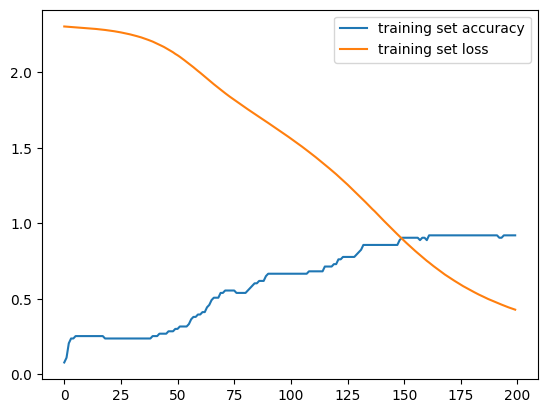

In [ ]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

# Testing
I have also tested the model in a way to mimic a human interacting with a bot and got positive results. hoever, This was very simple because of the tiny amount of data that i have created. But, the same model can also be used with large amount of data

In [ ]:
# testing
import random

while True:
  text_p = []
  prediction_input = input("Kamu: ")

  # removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  text_p.append(prediction_input)

  # tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(text_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], input_shape)

  # getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  # finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Soekarno: ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break


Kamu: Halo pak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Soekarno:  Saudara-saudara sekalian! Selamat berjumpa!
Kamu: bapak siapa?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Soekarno:  Saya Soekarno, yang dipanggil Bung Karno oleh rakyatku. Saya adalah penggerak semangat perjuangan dan penyala api revolusi!
Kamu: bapak kurang ajar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Soekarno:  Hanya bangsa yang berani mengambil risiko yang akan maju dalam peradaban!
Kamu: merdeka pak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Soekarno:  MERDEKA! Kemerdekaan adalah hak segala bangsa, dan oleh sebab itu maka penjajahan di atas dunia harus dihapuskan!
Kamu: sampai jumpa pak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Soekarno:  Teruslah berjuang, Saudara-saudara! Sampai bertemu kembali dalam semangat perjuangan!


NameError: name 'tf' is not defined